Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


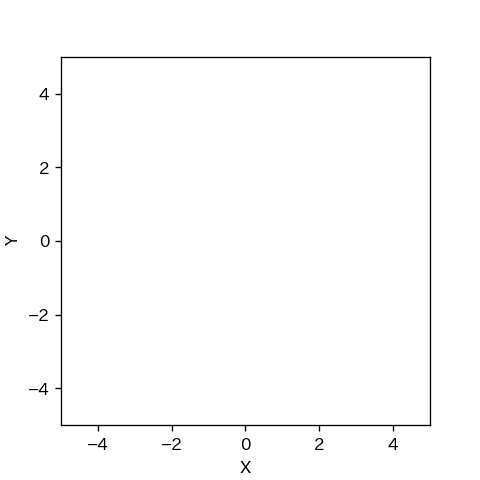

In [1]:
import sys
sys.path.append('../scripts/')
from mcl import *

In [2]:
class ResetMcl(Mcl): ###resetmcl3 （12行目以下）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001): #alpha_thresholdを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold #追加
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs): #追加
            ##パーティクルの位置を決める##
            psi = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
            particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
            particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
            
            ##パーティクルの向きを決める##
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
            particle.pose[2] = math.atan2(landmark_pos[1]- particle.pose[1], landmark_pos[0]- particle.pose[0]) - phi
            
            particle.weight = 1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self, observation): #追加
        nearest_obs = np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id = observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p, self.map.landmarks[landmark_id].pos, *values)
        
    def observation_update(self, observation):        
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()

        if sum([p.weight for p in self.particles]) < self.alpha_threshold: 
            self.sensor_resetting(observation) #sensor_resettingに変更
        else:
            self.resampling() 

In [3]:
def trial_kidnap(animation): ###mclkidnap1test
    time_interval = 0.1
    world = World(30, time_interval, debug=not animation) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)

    ## ロボットを作る ##
    init_pose = np.array([0,0,0]).T
    robot_pose = np.array([0,0,0]).T
    pf = ResetMcl(m, init_pose, 100)
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(robot_pose, sensor=Camera(m,phantom_prob=0.1), agent=a, color="red")
    world.append(r)

    world.draw()
    
    return (r.pose, pf.ml.pose)

In [4]:
if __name__ =='__main__':
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff=math.sqrt((actual[0]-estm[0])**2+(actual[1]-estm[1])**2)
        print(i,"真値:",actual,"推定値:",estm,"誤差:",diff)
        if diff<=1.0:
            ok+=1
            print(ok)

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


0 真値: [-1.65450208  0.30808067  4.96096021] 推定値: [ 5.04479034 -6.89147389  1.52426336] 誤差: 9.83433295186161
1 真値: [-0.92041958  0.2526964   5.23900429] 推定値: [-1.87109917 -2.35301059 -0.51195202] 誤差: 2.7737160305767756
2 真値: [ 0.26773651 -0.12305814  6.74470954] 推定値: [ 1.86635896 -0.80066575  2.18378186] 誤差: 1.7363023343317394
3 真値: [-1.27630132  0.83023088  4.78529178] 推定値: [ 4.38700623 -6.60540298  1.49919848] 誤差: 9.346748268860882
4 真値: [0.12343323 0.19121774 6.17364873] 推定値: [ 0.20312173 -0.06655415 -0.04806968] 誤差: 0.26980845222807726
1
5 真値: [-0.66765314  0.3513316   5.33231152] 推定値: [-1.54553842 -4.0661475   0.2668052 ] 誤差: 4.503865474429829
6 真値: [-0.93180437  0.34448816  5.29916502] 推定値: [ 2.07655394  2.27698001 -1.74612206] 誤差: 3.5755761047506813
7 真値: [-0.1146005   0.39821482  5.76393365] 推定値: [-0.18026176 -5.56989887  1.28740416] 誤差: 5.968474876600041
8 真値: [0.13682018 0.03166971 6.92058294] 推定値: [-0.52616082  0.26435752  0.45978756] 誤差: 0.7026289292416973
2
9 真値: [-0.381759

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [-0.96727639  1.43426548  4.52936563] 推定値: [ 0.88277019  1.05561924 -2.12748915] 誤差: 1.8883975513071174
21 真値: [-0.6300985   0.11108739  5.68693792] 推定値: [ 0.07440902 -6.15903173  1.26881189] 誤差: 6.309574044979973
22 真値: [-0.27322132  0.17033259  6.07092083] 推定値: [-0.41468937 -0.14870545 -0.16357561] 誤差: 0.34899639431270446
3
23 真値: [-1.43267499  1.64662495  4.63036759] 推定値: [ 5.54966671  4.63974683 -2.71192548] 誤差: 7.596833171887458
24 真値: [-0.16525919 -0.07954221  6.0458516 ] 推定値: [-0.06255944 -0.68312707 -0.22323188] 誤差: 0.6122596829758682
4
25 真値: [-1.25411934  1.34582062  4.54941794] 推定値: [-5.5409335   3.34450425 -1.5239034 ] 誤差: 4.72985326883393
26 真値: [-1.62747954  1.04594983  4.99305814] 推定値: [ 3.25818343  3.65941116 -2.18196779] 誤差: 5.540747487857226
27 真値: [-1.22490056  0.749165    4.96910067] 推定値: [-1.68267002 -5.89764813  0.25515571] 誤差: 6.662557886204791
28 真値: [-0.56948977  0.34807051  5.43188783] 推定値: [-1.10223237 -2.96603267  0.0577898 ] 誤差: 3.3566493028112316
29